In [31]:
%matplotlib inline
import numpy as np


State = (cars_loc1, cars_loc2) 每方最多20辆车

行为 每晚最多移动-5～5辆车从loc1到loc2

奖励 R 每租出去1辆车，奖励$10

状态转移概率
租车还车服从泊松分布
 - 第一个地点 平均租车3，返还3
 - 第二个地点 平均租车4， 返还2


In [99]:
def dynamics(s, a):
    '''Jack Car 租赁问题的动力学，包含泊松分布等随机性
    Args:
        s 两地(loc1, loc2)汽车库存数 tuple (n1, n2) 0<=n1,n2<=20
        a 转场汽车数 int 定义为从 loc1转运a辆车至loc2地，负数表示反向搬运 -5<=a<=5
    Returns:
        s_prime 后续状态 tuple(int, int) (n1,n2)
        reward float 奖励，两地合算，每租出1辆车，奖励10
        is_end Bool 本例可循环，没有终止状态，返回False
    '''
    if s[0]-a > 20:
        a = s[0] - 20
    if s[1]+a > 20:
        a = 20 - s[1]
#     if s[0] - a > 20 or s[1] + a > 20:
#         return s, 0, False
    s_prime = (s[0]-a, s[1]+a)
    reward = R(s, a)
    is_end = False
#     s_prime, reward, is_end = None, None, False
    # Add your code here
    return s_prime, reward, is_end

def poisson_prob(n, lamda):
    '''计算从一个参数为n定义的泊松分布中，采样输出为lamda的概率
    lambda是poisson prob的期望和方差，n表示事件实际发生的次数
    P(X=n)=\frac{e^-lambda * \lambda^n}{n!}, n=0, 1, 2...
    '''
    if lamda < 0:
        return 0.0
    return np.power(lamda,n)*np.power(np.e, -lamda) / np.math.factorial(n)

def _need_return(car_rent, loc_s0, loc_s1):
    '''借出car_rent辆车，需要有多少辆车返回才能满足从loc_s0->loc_s1
    解释：已知在地点loc，在状态为s0时刻有loc_s0辆车子，在状态为s1时刻有loc_s1辆车子，并且状态从s0->s1时，已知
    出租了car_rent辆车，那么为了满足s0->s1，需要计算在该地点回收的车子数量，
    为car_rent + (loc_s1 - loc_s0)
    '''
    return car_rent + (loc_s1 - loc_s0)

def prob_one_location(n_rent, n_return, loc_s0, loc_s1):
    '''计算由借出和返还泊松参数决定的随机事件中，某一地点的汽车数量从loc_s0变为loc_s1的概率。
    例如loc1处的状态，从s0变成s1的概率
    从s0变成s1的路径有很多，只需要满足借出的车辆+回收的车辆，满足s0->s1之间的差距即可。因此需要计算出借和回收的概率，使得满足该条件
    再将两个概率相乘，得到了该路径的概率。
    n_rent表示期望出借数量
    n_return表示期望回收数量
    '''
    max_for_rent = loc_s0 # 当前最大可借出数量
    prob = 0 # 初始概率设为0
    for car_rent in range(0, max_for_rent):# 对于每一个实际上借出数量为car_return的可能性
        prob_rent = poisson_prob(n_rent, car_rent) # 当期望出借数量为n_rent时，实际借出car_rent辆汽车的概率
        # 借出car_rent辆车，需要有car_need_return辆返回才能满足最终汽车数为loc_s1
        car_need_return = _need_return(car_rent, loc_s0, loc_s1)
        if car_need_return < 0: # 不需要在该地方额外回收车。
        # <0 说明借的不够多，将在借出里考虑计算，不重复计算
            prob_return = 0.0 # 这种情况一般不可能发生，因为出借了car_rent辆车，在还没有回收车之前，s1的状态不可能比s0要多
            # 而car_need_return<0的意思就是出借了汽车，后续状态却比当前状态数量还要多，这是不可能的
            # continue
        # 当期望回收数量为n_return时，实际回收了car_need_return辆汽车的概率
        prob_return = poisson_prob(n_return, car_need_return)
        prob += prob_rent * prob_return # 概率乘积
    return prob
    
def reward_one_location(n_rent, loc_aftmv):
    """
    n_return：期望出借数量
    loc_aftmv： 转移汽车后，地点loc的汽车数量
    返回的reward是地点loc的期望回报（价值）
    """
    reward = 0
    for cars in range(loc_aftmv + 1):
        # 出借cars辆车，得到cars的回报， 乘以该地点出借cars辆车的概率
        reward += cars * poisson_prob(n_rent, cars)
    return reward

In [18]:
# 期望发生2次，实际发生了5次的概率
poisson_prob(5, 2)

0.03608940886309672

In [19]:
print(_need_return(3,5,2))
# s0有5辆车，当出租的3辆车，s1有2辆车，此时需要回收0辆车。
print(prob_one_location(3,3,4,3))
# 出租和回收车的期望数量分别为3和3,当状态从s0=4变成s1=3的概率
print(reward_one_location(3,5))
# 当前该地方车辆数量为5,出租车辆的期望数量为3,这种状态下的期望回报（价值）

0
0.05149147496514925
2.5776694901164325


In [20]:
def P(s, a, s1):
    '''重新改写状态转换概率
    由于s和s1同时表达了loc1和loc2，因此需要整体考虑
    '''
    n1, n2 = s # 当前1,2两地汽车数量数目
    if not(0<= n1 <= MAX_CARS and 0<= n2 <= MAX_CARS):
        #"初始状态不合法"
        return 0.0
    n1_aftmv, n2_aftmv = n1 - a, n2 + a # 移动a辆汽车后两地汽车数量
    if not(0<= n1_aftmv <= MAX_CARS and 0 <= n2_aftmv <= MAX_CARS): 
        # "转场的汽车数不符合要求"
        return 0.0
    n1_prime, n2_prime = s1
    # loc1处，s0=n1_aftmv，s1=n1_prime的概率
    prob = prob_one_location(params["loc1_rent"],
                             params["loc1_return"],
                             n1_aftmv, n1_prime)
    # 乘以loc2处，s0=n2_aftmv，s1=n2_prime的概率
    prob *= prob_one_location(params["loc2_rent"],
                              params["loc2_return"],
                              n2_aftmv, n2_prime)
    return prob


def R(s, a):
    # 需要整体考虑两个地方的回报期望
    n1, n2 = s # 当前1,2两地汽车数量数目
    if not(0<= n1 <= MAX_CARS and 0<= n2 <= MAX_CARS):
        #"初始状态不合法"
        return 0.0
    n1_aftmv, n2_aftmv = n1 - a, n2 + a # 移动a辆汽车后两地汽车数量
    if not(0<= n1_aftmv <= MAX_CARS and 0 <= n2_aftmv <= MAX_CARS): 
        # "转场的汽车数不符合要求"
        return 0.0
    reward = 0
    reward += reward_one_location(params["loc1_rent"], n1_aftmv)
    reward += reward_one_location(params["loc2_rent"], n2_aftmv)
    return reward
    
def set_value(V, s, v):
    loc1, loc2 = s
    V[loc1,loc2] = v
    
def get_value(V, s):
    loc1, loc2 = s
    return V[loc1, loc2]

def display_V(V):
    print(V)
    
gamma = 1
MDP = S, A, R, P, gamma   


In [50]:
#from utils import get_prob, get_reward
#from utils import get_pi, uniform_random_pi, greedy_pi
#from utils import policy_evaluate, policy_iterate, value_iterate
from tqdm import tqdm
'''
def P(s, a, s1):
    s_prime, _, _ = dynamics(s, a)
    return s1 == s_prime

def R(s, a):
    _, r, _ = dynamics(s, a)
    return r
'''
def get_prob(P, s, a, s1):
    # get P_ss1^a
    return P(s, a, s1)

def get_reward(R, s, a):
    # get R_s^a
    return R(s, a)

########################

def get_pi(Pi, s, a, MDP = None, V = None): # 返回概率
    return Pi(MDP, V, s, a)

def uniform_random_pi(MDP = None, V = None, s = None, a = None):
    _, A, _, _, _ = MDP
    n = len(A)
    return 0 if n == 0 else 1.0/n

def greedy_pi(MDP, V, s, a):
    # 如果a是argmax_a（V）,则返回take a的概率。
    # 否则返回0
    S, A, P, R, gamma = MDP
    max_v, a_max_v = -float('inf'), []
    for a_opt in A:# 统计后续状态的最大价值以及到达到达该状态的行为（可能不止一个）
        s_prime, reward, _ = dynamics(s, a_opt)
        v_s_prime = get_value(V, s_prime)
        if v_s_prime > max_v:
            max_v = v_s_prime
            a_max_v = [a_opt]
        elif(v_s_prime == max_v):
            a_max_v.append(a_opt)
    n = len(a_max_v)
    if n == 0: return 0.0
    return 1.0/n if a in a_max_v else 0.0


def epsilon_greedy_pi(MDP, V, s, a, epsilon = 0.1):
    if MDP is None:
        return 0.0
    _, A, _, _, _ = MDP
    m = len(A)
    greedy_p = greedy_pi(MDP, V, s, a)
    if greedy_p == 0: # 当greedy_p=0，表示a不是argmax_a（V），此时进入随机模式
        return epsilon / m
    # n = int(1.0/greedy_p)
    return (1 - epsilon + epsilon/m) * greedy_p


def compute_q(MDP, V, s, a):
    '''根据给定的MDP，价值函数V，计算状态行为对s,a的价值qsa
    take action a，可能会将agent带到任何状态，因此需要对s遍历
    q_pi(s,a)=R + gamma * \sum_{s'}{P_ss'^a * V(s')}
    '''
    S, A, R, P, gamma = MDP
    q_sa = 0
    for s_prime in S:
        q_sa += get_prob(P, s, a, s_prime) * get_value(V, s_prime)
    q_sa = get_reward(R, s,a) + gamma * q_sa
    return q_sa


def compute_v(MDP, V, Pi, s):
    '''给定MDP下依据某一策略Pi和当前状态价值函数V计算某状态s的价值
    v_pi(s) = \sum_{a}{pi(a|s) * q(s,a)}
    '''
    S, A, R, P, gamma = MDP
    v_s = 0
    for a in A:
        v_s += get_pi(Pi, s, a, MDP, V) * compute_q(MDP, V, s, a)
    return v_s        

def update_V(MDP, V, Pi):
    '''给定一个MDP和一个策略，更新该策略下的价值函数V
    更新一次所有状态的value
    '''
    S, _, _, _, _ = MDP
    V_prime = V.copy()
    for s in S:
        #print("in update V, for state s")
        set_value(V_prime, s, compute_v(MDP, V_prime, Pi, s))
    return V_prime


def policy_evaluate(MDP, V, Pi, n):
    '''使用n次迭代计算来评估一个MDP在给定策略Pi下的状态价值，初始时价值为V
    '''
    for i in tqdm(range(n)):
        #print("====第{}次迭代====".format(i+1))
        V = update_V(MDP, V, Pi)
        #display_V(V)
    return V

def policy_iterate(MDP, V, Pi, n, m):
    cur_Pi = Pi
    for i in range(m):
        V = policy_evaluate(MDP, V, Pi, n) # evaluate
        Pi = epsilon_greedy_pi # improvement
        #print("改善了策略")
    return V

# 价值迭代得到最优状态价值过程
def compute_v_from_max_q(MDP, V, s):
    '''根据一个状态的下所有可能的行为价值中最大一个来确定当前状态价值
    v(s) = max q(s,a)
    '''
    S, A, R, P, gamma = MDP
    v_s = -float('inf')
    for a in A:
        qsa = compute_q(MDP, V, s, a)
        if qsa >= v_s:
            v_s = qsa
    return v_s

def update_V_without_pi(MDP, V):
    '''在不依赖策略的情况下直接通过后续状态的价值来更新状态价值
    '''
    S, _, _, _, _ = MDP
    V_prime = V.copy()
    for s in tqdm(S):
        set_value(V_prime, s, compute_v_from_max_q(MDP, V_prime, s))
    return V_prime

def value_iterate(MDP, V, n):
    '''价值迭代
    '''
    for i in range(n):
        V = update_V_without_pi(MDP, V)
        display_V(V)
    return V

In [26]:
# initialization

# 动态规划算法时间复杂度随着状态数量和行为数量的增多而成平方级别增多，
# 本例中的状态数为21*21=441,行为数为11,按照动态规划算法完成一次迭代话费计算资源较昂贵
# |[0,20]|=21
# |[-5,5]|=11
# 
MAX_CARS = 20
MAX_MOVE = 5
S = []
# 每个元素是一个tuple，分别表示该状态下两个地方的车辆数
for i in range(MAX_CARS+1):
    for j in range(MAX_CARS+1):
        S.append((i,j))

# 每个元素是一个数值，表示从loc1移动到loc2的车辆数，负值表示从loc2移动到loc1
A = [i for i in range(-MAX_MOVE,MAX_MOVE+1)]
params = {
    "loc1_rent":3,
    "loc1_return":3,
    "loc2_rent":4,
    "loc2_return":2
}
# print(S)
# print(A)

In [27]:
print('size of state space is {}'.format(len(S)))
print('size of action space is {}'.format(len(A)))

size of state space is 441
size of action space is 11


In [28]:
V = np.zeros((MAX_CARS+1, MAX_CARS+1))
V_pi = value_iterate(MDP, V, 4)
#V_pi = policy_evaluate(MDP, V, uniform_random_pi, 1)
display_V(V_pi)

  1%|          | 4/441 [00:00<00:20, 21.72it/s]

[[ 0.          0.06131324  0.42220733  1.09433275  1.87580001  2.57766949
   3.16178923  3.80037258  4.25839088  4.56202528  5.03758925  5.73945873
   6.37804207  6.83606037  7.13969477  7.32886115  7.44093721  7.50464041
   7.53960893  7.55824293  7.56792187]
 [ 0.06131324  0.42220733  1.09433275  1.87580001  2.57766949  3.16178923
   3.80037258  4.25839088  4.56202528  5.03758925  5.73945873  6.37804207
   6.91345254  7.37147084  7.67510524  7.86427162  7.97634768  8.04005088
   8.0750194   8.0936534   8.10333234]
 [ 0.42220733  1.09433275  1.87580001  2.57766949  3.16178923  3.80037258
   4.25839088  4.56202528  5.06451559  5.76557431  6.41275842  6.9397357
   7.40354918  7.75727161  8.06431899  8.25669201  8.37180835  8.43835969
   8.47592674  8.4968527   8.50847802]
 [ 1.09433275  1.87580001  2.57766949  3.16178923  3.80037258  4.25839088
   4.56202528  5.16779921  5.87919485  6.56409555  7.06478431  7.55559115
   7.88950474  8.18574679  8.39340142  8.55812392  8.68036119  8.75320

  1%|          | 3/441 [00:00<00:14, 29.35it/s]

[[ 0.          0.06131324  0.42220733  1.09433275  1.87580001  2.57766949
   3.16178923  3.80037258  4.25839088  5.70741663  7.22587103  9.05501846
  10.61713999 11.85777086 12.80631173 13.52033423 14.05599013 14.45744802
  14.75578962 14.97082325 15.11219941]
 [ 0.06131324  0.42220733  1.09433275  1.87580001  2.57766949  3.16178923
   3.80037258  4.25839088  5.70741663  7.22587103  9.05501846 10.74220223
  12.60397501 14.0844503  15.21705802 16.06929339 16.70744052 17.18381251
  17.53515842 17.78452849 17.94236579]
 [ 0.42220733  1.09433275  1.87580001  2.57766949  3.16178923  3.80037258
   4.25839088  5.70741663  7.2264133   9.05714872 10.74440117 12.60869624
  14.36401645 16.05748556 17.34636468 18.31026229 19.02706388 19.55793525
  19.94530913 20.2149925  20.37756563]
 [ 1.09433275  1.87580001  2.57766949  3.16178923  3.80037258  4.25839088
   5.70994764  7.23175814  9.07307726 10.7609354  12.64108691 14.38839172
  16.09736073 17.85460499 19.28176718 20.34044555 21.12125827 21.6946

  1%|          | 4/441 [00:00<00:21, 20.80it/s]

[[ 0.          0.06131324  0.42220733  1.09433275  1.87580001  2.57766949
   3.16178923  3.80037258  4.43292052  6.21721008  8.04981545 10.38077221
  12.51538028 14.38307293 16.00231958 17.42073271 18.68361835 19.82299068
  20.85576286 21.78332919 22.58913433]
 [ 0.06131324  0.42220733  1.09433275  1.87580001  2.57766949  3.16178923
   3.80037258  4.43292052  6.21721008  8.04981545 10.38077221 12.56286144
  15.17089785 17.44861379 19.41587412 21.12922498 22.64342359 23.99802683
  25.21517641 26.29897767 27.23207759]
 [ 0.42220733  1.09433275  1.87580001  2.57766949  3.16178923  3.80037258
   4.43292052  6.21736697  8.05019368 10.38187484 12.56392267 15.1730462
  17.55659885 20.17955347 22.41866047 24.34322624 26.02073073 27.50080261
  28.81281047 29.96559967 30.94386535]
 [ 1.09433275  1.87580001  2.57766949  3.16178923  3.80037258  4.43343254
   6.21927977  8.05332    10.38971028 12.57170936 15.18762682 17.56759121
  20.19729207 22.66026397 25.11415493 27.18845445 28.96597439 30.50801

100%|██████████| 441/441 [08:07<00:00,  1.11s/it]

[[0.00000000e+00 6.13132402e-02 4.22207329e-01 1.09433275e+00
  1.87580001e+00 2.57766949e+00 3.16178923e+00 3.80037258e+00
  4.55894888e+00 6.46946289e+00 8.46085741e+00 1.10492032e+01
  1.34866295e+01 1.56995889e+01 1.77058247e+01 1.95516010e+01
  2.12786929e+01 2.29129110e+01 2.44625479e+01 2.59184212e+01
  2.72506183e+01]
 [6.13132402e-02 4.22207329e-01 1.09433275e+00 1.87580001e+00
  2.57766949e+00 3.16178923e+00 3.80037258e+00 4.55894888e+00
  6.46946289e+00 8.46085741e+00 1.10492032e+01 1.34932569e+01
  1.65049489e+01 1.92335422e+01 2.16974503e+01 2.39515460e+01
  2.60463886e+01 2.80140498e+01 2.98661185e+01 3.15936047e+01
  3.31626339e+01]
 [4.22207329e-01 1.09433275e+00 1.87580001e+00 2.57766949e+00
  3.16178923e+00 3.80037258e+00 4.55894888e+00 6.46957618e+00
  8.46107560e+00 1.10498019e+01 1.34938227e+01 1.65060737e+01
  1.92445366e+01 2.24075198e+01 2.52300153e+01 2.77797377e+01
  3.01199745e+01 3.22924789e+01 3.43151744e+01 3.61823655e+01
  3.78601550e+01]
 [1.09433275e+00

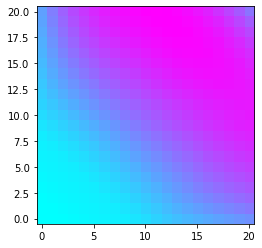

In [36]:
import matplotlib.pyplot as plt
plt.imshow(V_pi, cmap=plt.cm.cool, interpolation=None, origin="lower")#, extent=[0, 11, 0, 22])
# 横坐标表示loc1的车辆数，纵坐标表示loc2的车辆数
# 颜色越蓝，表示数值越小，越紫表示数值越大
# 可以看到当两个地方的车辆数越多的时候，公司的V value越大（非常直觉，在不考虑仓储费的情况下，确实是车辆越多，能出租车同时赚更多的钱就越多）

In [94]:
def greedy_policy(MDP, V, s):
    """
    直接输出v值最大的a。由于take action是deterministic的去到对应的后续状态，因此可以直接看后续状态的价值v来选择action a
    """
    S, A, P, R, gamma = MDP
    max_v, a_max_v = -float('inf'), ''
    for a_opt in A:# 统计后续状态的最大价值以及到达到达该状态的行为（可能不止一个）
        s_prime, reward, _ = dynamics(s, a_opt)
        v_s_prime = get_value(V, s_prime)
        if v_s_prime > max_v:
            max_v = v_s_prime
            a_max_v = a_opt
#         elif(v_s_prime == max_v):
#             a_max_v += a_opt
    return str(a_max_v)

In [101]:
v_a = np.zeros((MAX_CARS+1,MAX_CARS+1))
for i in range(MAX_CARS+1):
    for j in range(MAX_CARS+1):
        s = (i, j)
        v_a[i,j] = greedy_policy(MDP, V_pi, s)

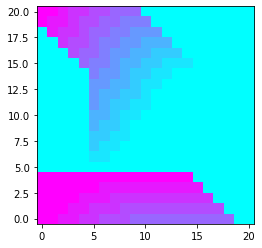

In [102]:
plt.imshow(v_a, cmap=plt.cm.cool, interpolation=None, origin="lower")#, extent=[0, 11, 0, 22])
# 在状态为V_pi的情况下，利用greedy policy作为策略指导进行action
# 颜色越蓝，表示数值越小，越紫表示数值越大
# 图中loc1取值在0-17，同时loc2取值在0-4左右，将车辆从loc1移动至loc2，是策略贪婪选择的结果
# 图中loc1取值在0-4，同时loc2取值在5-18左右，将车辆从loc2移动至loc1，是策略贪婪选择的结果


In [103]:
import pandas as pd
pd.DataFrame(v_a)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,5.0,5.0,4.0,4.0,3.0,3.0,2.0,2.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-5.0,-5.0
1,5.0,5.0,5.0,4.0,4.0,3.0,3.0,3.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-5.0,-5.0,-5.0
2,5.0,5.0,5.0,5.0,4.0,4.0,4.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,-5.0,-5.0,-5.0,-5.0
3,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,-5.0,-5.0,-5.0,-5.0,-5.0
4,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0
5,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,...,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0
6,-5.0,-5.0,-5.0,-5.0,-5.0,-4.0,-4.0,-5.0,-5.0,-5.0,...,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0
7,-5.0,-5.0,-5.0,-5.0,-5.0,-3.0,-4.0,-4.0,-5.0,-5.0,...,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0
8,-5.0,-5.0,-5.0,-5.0,-5.0,-3.0,-3.0,-4.0,-4.0,-5.0,...,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0
9,-5.0,-5.0,-5.0,-5.0,-5.0,-2.0,-3.0,-3.0,-4.0,-5.0,...,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0
